<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/practica_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica 14

Modelos fisicos parte 2 y análisis de sensibilidad

In [1]:
import io, os
import numpy as np
import scipy.stats as st
import scipy.special as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pymc
import pymc as pm
import arviz as az
import pandas as pd
import aesara.tensor as at

In [2]:
!pip install openseespy
import openseespy.opensees as op

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 3.9 MB/s 


## Funciones auxiliares

In [3]:
# definir unf función (Op) en aesara para la función
class custom_f(at.Op):

    """
    Especificar qué tipo de objetas serán pasados y devueltos por la función (Op)
    cuando es llamada. En este caso, el input de la función es un vector de 2
    valores (los parámetros a calibrar del modelo) y el output de la función es
    también un vector (la función para todos los valores observados de x)
    """

    itypes = [at.dvector]  # expects a vector of parameter values when called
    otypes = [at.dvector]  # outputs a vector value

    def __init__(self, cfunc, x):
        self.cfunc = cfunc # La función externa
        self.x = x # Los parámetros observables

    def perform(self, node, inputs, outputs):
        # Este método es usado cada vez que se llama a la función

        (theta,) = inputs # this will contain my variables

        # Llamar a la función externa
        f = self.cfunc(theta, self.x)

        outputs[0][0] = f  # output the function values

## Ejemplo 1: Identificabilidad de parámetros

In [4]:
def nonlinear_truss( A, E, alpha, sY, Py, Pxmax, px ):
    """
    A: área de la sección
    E: módulo de elasticidad longitudinal
    alpha: Factor del módulo de endurecimiento cinemático Hcin=alpha/(1-alpha)*E
    sY: tensión de fluencia
    Py: componente vertical de la carga (constante)
    Pxmax: componente lateral de la carga máxima
    px: valores intermedios de la carga Px para la cual devolver los desplazamientos
    """

    # ------------------------------
    # Start of model generation
    # -----------------------------

    # set modelbuilder
    op.wipe()
    op.model('basic', '-ndm', 2, '-ndf', 2)

    # variables
    udisp = 2.5
    Nsteps = 1000

    # create nodes
    op.node(1, 0.0, 0.0)
    op.node(2, 72.0, 0.0)
    op.node(3, 168.0, 0.0)
    op.node(4, 48.0, 144.0)

    # set boundary condition
    op.fix(1, 1, 1)
    op.fix(2, 1, 1)
    op.fix(3, 1, 1)

    # define materials
    op.uniaxialMaterial("Hardening", 1, E, sY, 0.0, alpha/(1-alpha)*E)

    # define elements
    op.element("Truss",1,1,4,A,1)
    op.element("Truss",2,2,4,A,1)
    op.element("Truss",3,3,4,A,1)

    # create TimeSeries
    op.timeSeries("Linear", 1)

    # create a plain load pattern
    op.pattern("Plain", 1, 1)

    # Create the nodal load
    op.load(4, Pxmax, Py)

    # ------------------------------
    # Start of analysis generation
    # ------------------------------

    # create SOE
    op.system("ProfileSPD")
    # create DOF number
    op.numberer("Plain")
    # create constraint handler
    op.constraints("Plain")
    # create integrator
    op.integrator("LoadControl", 1.0/Nsteps)
    # create algorithm
    op.algorithm("Newton")
    # create test
    op.test('NormUnbalance',1e-8, 10)
    # create analysis object
    op.analysis("Static")

    # ------------------------------
    # Finally perform the analysis
    # ------------------------------

    # perform the analysis
    data = np.zeros((Nsteps+1,2))
    for j in range(Nsteps):
        op.analyze(1)
        data[j+1,0] = op.nodeDisp(4,1)
        data[j+1,1] = op.getLoadFactor(1)*Pxmax

    # Find data for ps
    data_out = np.zeros([px.size,2])
    for i in range(px.size):
        ix = np.where(data[:,1]<=px[i])[0][-1]
        data_out[i,:] = data[ix,:]

    return data, data_out[:,0]

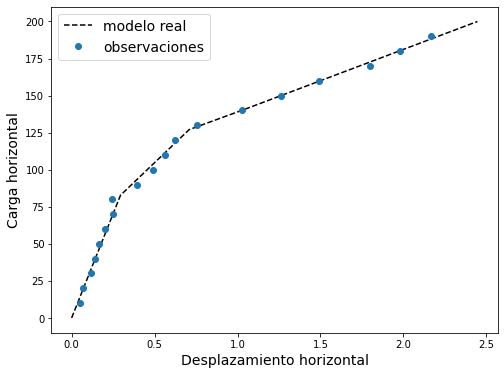

In [5]:
np.random.seed(523)

# Creación de observaciones a partir de un modelo "real" más ruido
A = 4
E_true = 29000
Pmax = 200
Py = 300
sY = 36
alpha_true = 0.15
x = np.arange( 10, Pmax, 10 )
data, disp_out = nonlinear_truss( A, E_true, alpha_true, sY, Py, Pmax, x )
y = disp_out + st.norm.rvs( size=x.size, scale=0.02 )

# Ploteo de obsrevaciones sintéticas
fig, ax = plt.subplots( figsize=(8,6) )
ax.plot(data[:,0], data[:,1],'k--', label='modelo real')
ax.plot( y, x, 'C0o', label='observaciones' )
ax.set_xlabel('Desplazamiento horizontal', fontsize=14)
ax.set_ylabel('Carga horizontal', fontsize=14)
ax.legend( fontsize=14 );

### Calibración con 2 parámetros

In [7]:
# Función externa
def f_externa(beta, x):
    Pmax = 200
    Py = 300
    A = 4
    sY =36
    E, alpha = beta # Parámetros a calibrar
    _, disp_out = nonlinear_truss( A, E, alpha, sY, Py, Pmax, x )
    return disp_out

# Crear Op de aesara
f_externa_op = custom_f(f_externa, x)

In [ ]:
with pm.Model() as model_01:

    # Prioris
    E = pm.LogNormal("E", mu=10, sigma=0.5)
    alpha = pm.Uniform("alpha", lower=0.01, upper=0.6)
    A = pm.Uniform("A", lower=1, upper=10)
    sigma = pm.Exponential("sigma", lam=1)

    # Función media
    beta = pm.math.stack([E, alpha])
    mu = pm.Deterministic( "mu", f_externa_op(beta) )

    # Verosimilitud
    y_ = pm.Normal("y_", mu=mu, sigma=sigma, observed=y)

    # Simulaciones posteriores
    trace_01 = pm.sample( 3000, tune=2000, cores=2 )

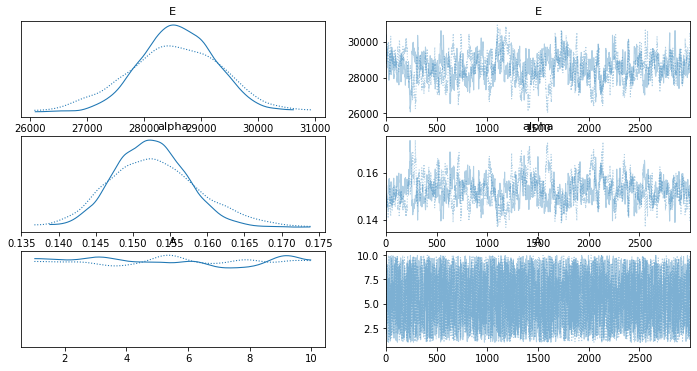

In [10]:
az.plot_trace( trace_01, var_names=['~mu','~sigma'] );

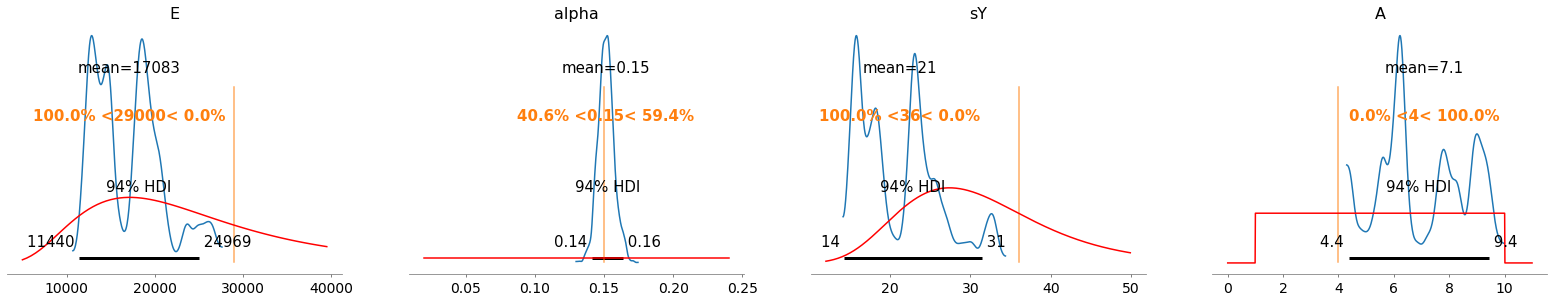

In [ ]:
ax = az.plot_posterior( trace_01, var_names=['~mu','~sigma'], ref_val=[E_true,alpha_true] )

xplot1 = np.arange(5000,40000,500)
ax[0].plot( xplot1, st.lognorm.pdf( xplot1, s=0.5, scale=np.exp(10)), color='r' )
xplot2 = np.arange(0.02,0.25,0.01)
ax[1].plot( xplot2, st.uniform.pdf( xplot2, loc=0.01, scale=(0.6-0.01)), color='r' )

### Calibración con 4 parámetros

In [ ]:
# Función externa
def f_externa(beta, x):
    Pmax = 200
    Py = 300
    E, alpha, A, sY = beta # Parámetros a calibrar
    _, disp_out = nonlinear_truss( A, E, alpha, sY, Py, Pmax, x )
    return disp_out

# Crear Op de aesara
f_externa_op = custom_f(f_externa, x)

In [ ]:
with pm.Model() as model_02:

    # Prioris
    E = pm.LogNormal("E", mu=10, sigma=0.5)
    alpha = pm.Uniform("alpha", lower=0.01, upper=0.6)
    A = pm.Uniform("A", lower=1, upper=10)
    sY = pm.Uniform("sY", lower=20, upper=60)
    sigma = pm.Exponential("sigma", lam=1)

    # Función media
    beta = pm.math.stack([E, alpha, A, sY])
    mu = pm.Deterministic( "mu", f_externa_op(beta) )

    # Verosimilitud
    y_ = pm.Normal("y_", mu=mu, sigma=sigma, observed=y)

    # Simulaciones posteriores
    trace_02 = pm.sample( 3000, tune=2000, cores=2 )

In [ ]:
ax = az.plot_posterior( trace_02, var_names=['~mu','~sigma'], ref_val=[E_true,alpha_true,36,4] )

xplot1 = np.arange(5000,40000,500)
ax[0].plot( xplot1, st.lognorm.pdf( xplot1, s=0.5, scale=np.exp(10)), color='r' )
xplot2 = np.arange(0.02,0.25,0.01)
ax[1].plot( xplot2, st.uniform.pdf( xplot2, loc=0.01, scale=(0.6-0.01)), color='r' )
xplot3 = np.arange(12,50,0.1)
ax[2].plot( xplot3, st.lognorm.pdf( xplot3, s=0.3, scale=np.exp(3.4)), color='r' );
xplot4 = np.arange(0,11,0.01)
ax[3].plot( xplot4, st.uniform.pdf( xplot4, loc=1, scale=9), color='r' );

## Ejemplo 1: modelo no lineal no identificable por estructura

Text(0, 0.5, 'y')

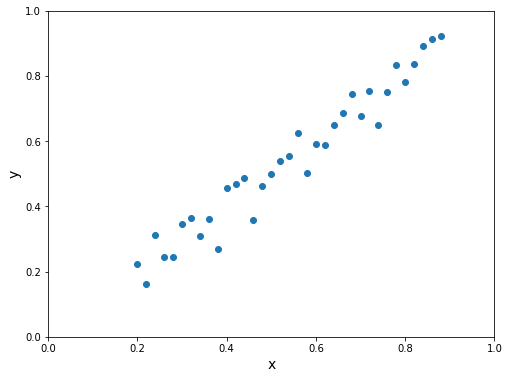

In [ ]:
np.random.seed(1234)
x = np.arange( 0.2, 0.9, 0.02 )
y = x + st.norm.rvs( size=x.size, scale=0.05 )

fig, ax = plt.subplots( figsize=(8,6) )

ax.plot( x, y, 'C0o' )

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)

Text(0, 0.5, 'b2')

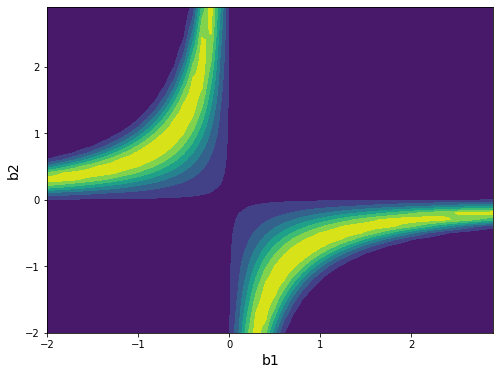

In [ ]:
b1coords = np.arange(-2,3,0.1)
b2coords = np.arange(-2,3,0.1)
b1grid, b2grid = np.meshgrid( b1coords, b2coords )

z = np.zeros(b1grid.shape)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        # z[i,j] = logl(0,b1grid[i,j],b2grid[i,j])
        z[i,j] = np.sum(st.norm.logpdf( y, loc=(1+b1grid[i,j]*b2grid[i,j]*x), scale=1))

fig, ax = plt.subplots( figsize=(8,6) )

ax.contourf( b1grid, b2grid, np.exp(z) )

ax.set_xlabel('b1', fontsize=14)
ax.set_ylabel('b2', fontsize=14)

In [ ]:
def NormalLogLikelihood( beta ):
    return np.sum(st.norm.logpdf( y, loc=(beta[0]+beta[1]*beta[2]*x), scale=1))

# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['b0', 'b1', 'b2'],
    'bounds': [[0,1],[0,1],[0,1]],
    'dists': ['norm','norm','norm']
}

# Simulaciones
param_values = saltelli.sample(problem, 2**10, calc_second_order=False)

# Evaluaciones
Y = np.zeros( param_values.shape[0] )
for i in range( param_values.shape[0] ):
    Y[i] = np.exp( NormalLogLikelihood( param_values[i] ) )

# Cómputo de índices
sobol_indices = sobol.analyze(problem, Y, calc_second_order=False)

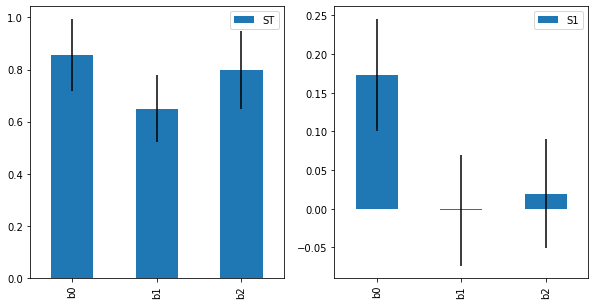

In [ ]:
ax = sobol_indices.plot()
fig = ax[0].get_figure()
fig.set_size_inches(10,5);

## Ejemplo 2: Modelo no identificable por datos

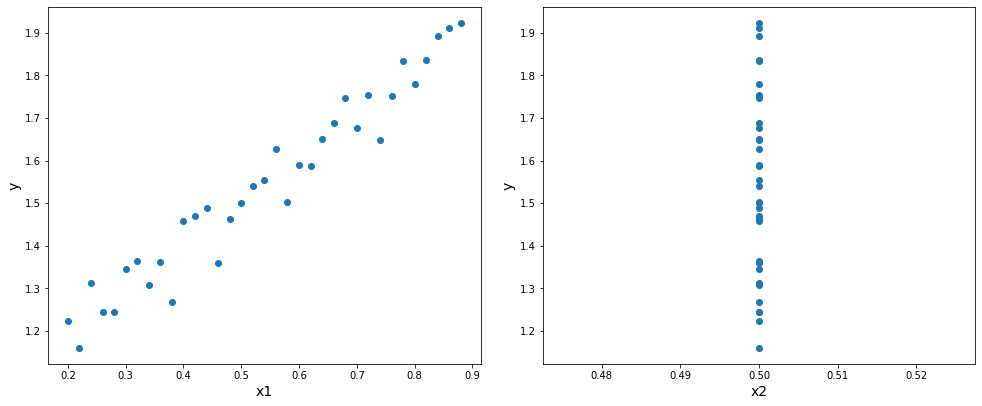

In [ ]:
np.random.seed(1234)
x1 = np.arange( 0.2, 0.9, 0.02 )
x2 = 0.5 * np.ones(x.size)
y = x1 + 2*x2 + st.norm.rvs( size=x.size, scale=0.05 )

fig, ax = plt.subplots( figsize=(14,6), ncols=2 )

ax[0].plot( x1, y, 'C0o' )
ax[1].plot( x2, y, 'C0o' )

ax[0].set_xlabel('x1', fontsize=14)
ax[0].set_ylabel('y', fontsize=14)

ax[1].set_xlabel('x2', fontsize=14)
ax[1].set_ylabel('y', fontsize=14)

fig.tight_layout(pad=2)

### Regresión

In [ ]:
with pm.Model() as model_1:

    # Prioris
    b0 = pm.Normal("b0", mu=0, sigma=1)
    b1 = pm.Normal("b1", mu=0, sigma=1)
    b2 = pm.Normal("b2", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)

    # Función media
    mu = pm.Deterministic( "mu", b0 + b1*x1 + b2*x2 )

    # Verosimilitud
    y_ = pm.Normal("y_", mu=mu, sigma=sigma, observed=y)

    # Simulaciones posteriores
    trace_11 = pm.sample( 3000, tune=2000, cores=2 )

### Análisis de sensibilidad

In [ ]:
def NormalLogLikelihood( beta ):
    return np.sum(st.norm.logpdf( y, loc=(beta[0]+beta[1]*x1 + beta[2]*x2), scale=1))

# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['b0', 'b1', 'b2'],
    'bounds': [[0,1],[0,1],[0,1]],
    'dists': ['norm','norm','norm']
}

# Simulaciones
param_values = saltelli.sample(problem, 2**11, calc_second_order=False)

# Evaluaciones
Y = np.zeros( param_values.shape[0] )
for i in range( param_values.shape[0] ):
    Y[i] = NormalLogLikelihood( param_values[i] )

# Cómputo de índices
sobol_indices = sobol.analyze(problem, Y, calc_second_order=False)

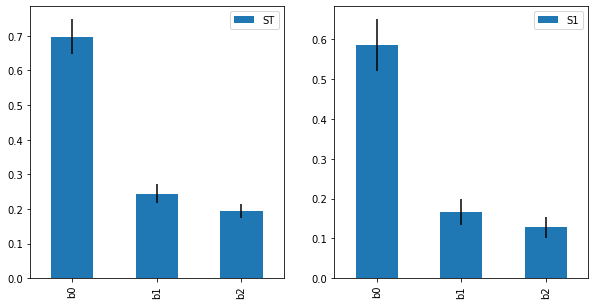

In [ ]:
ax = sobol_indices.plot()
fig = ax[0].get_figure()
fig.set_size_inches(10,5);

## Ejemplo 3: SA global

In [ ]:
!pip install SALib
from SALib.sample import saltelli
from SALib.analyze import sobol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 756 kB 7.7 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 115 kB 62.6 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 


### Modelo lineal

Dataset sintético de modelo lineal:
f(x) = x1 + 2x2 + 0.5x3

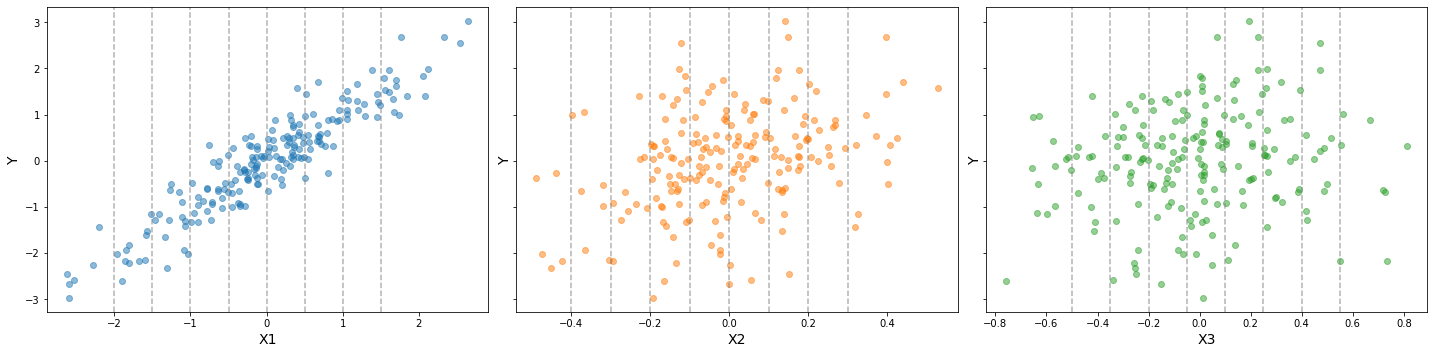

In [ ]:
# Generación del dataset sintético
np.random.seed(1234)
N = 200
x = st.multivariate_normal.rvs( size=N, cov=np.eye(3) )
x1 = st.norm.rvs( size=N, scale=1 )
x2 = st.norm.rvs( size=N, scale=0.2 )
x3 = st.norm.rvs( size=N, scale=0.3 )
# x3 = 0.3*np.ones( x2.shape )
x = np.vstack([x1,x2,x3]).T
phi = np.array([1,2,0.5])
Y = phi.dot(x.T)

In [ ]:
fig, ax = plt.subplots( figsize=(20,5), ncols=3, nrows=1, sharey=True )

ax[0].plot( x[:,0], Y, 'C0o', alpha=.5 )
ax[0].set_xlabel('X1', fontsize=14)
ax[0].set_ylabel('Y', fontsize=14)
rs = np.arange( -2, 2, 0.5 )
for r in rs:
    ax[0].axvline( r, color='gray', linestyle='--', alpha=.6 )

ax[1].plot( x[:,1], Y, 'C1o', alpha=.5 )
ax[1].set_xlabel('X2', fontsize=14)
ax[1].set_ylabel('Y', fontsize=14)
# ax[1].set_xlim([-3.1,3.1])
rs = np.arange( -0.4, 0.4, 0.1 )
for r in rs:
    ax[1].axvline( r, color='gray', linestyle='--', alpha=.6 )

ax[2].plot( x[:,2], Y, 'C2o', alpha=.5 )
ax[2].set_xlabel('X3', fontsize=14)
ax[2].set_ylabel('Y', fontsize=14)
# ax[2].set_xlim([-3.1,3.1])
rs = np.arange( -0.5, 0.6, 0.15 )
for r in rs:
    ax[2].axvline( r, color='gray', linestyle='--', alpha=.6 )

fig.tight_layout(pad=1);

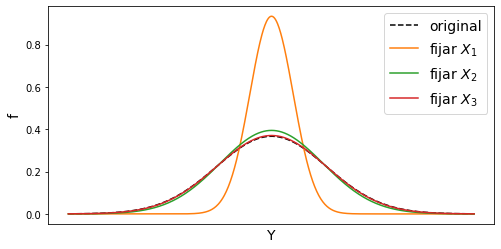

In [ ]:
xplot = np.arange(-4,4,0.01)
fig, ax = plt.subplots( figsize=(8,4) )
ax.plot( xplot, st.norm.pdf( xplot, scale=np.sqrt(1+(2*0.2)**2+(0.5*0.3)**2) ), color='k', linestyle='--')
ax.plot( xplot, st.norm.pdf( xplot, scale=np.sqrt((2*0.2)**2+(0.5*0.3)**2) ), color='C1')
ax.plot( xplot, st.norm.pdf( xplot, scale=np.sqrt(1**2+(0.5*0.3)**2) ), color='C2')
ax.plot( xplot, st.norm.pdf( xplot, scale=np.sqrt(1**2+(2*0.2)**2) ), color='C3')
ax.set_xlabel('Y', fontsize=14)
ax.set_ylabel('f', fontsize=14)
ax.set_xticks([])
ax.legend(['original',r'fijar $X_1$',r'fijar $X_2$',r'fijar $X_3$'], fontsize=14)

In [ ]:
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['X1','X2','X3'],
    'bounds': [[0,1],[0,0.2],[0,0.3]],
    'dists': ['norm', 'norm', 'norm']
}

# Simulaciones
X = saltelli.sample(problem, 2048, calc_second_order=False)

# Evaluaciones
Y = X[:,0] + 2*X[:,1] + 0.5*X[:,2]

# Cómputo de índices
sobol_indices = sobol.analyze(problem, Y, calc_second_order=False)

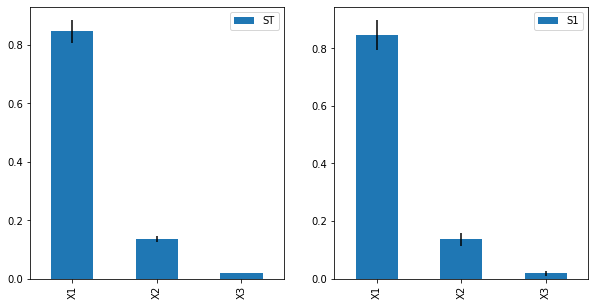

In [ ]:
# Cómputo de índices
sobol_indices = sobol.analyze(problem, Y, calc_second_order=False);

ax = sobol_indices.plot()
fig = ax[0].get_figure()
fig.set_size_inches(10,5);

### Modelo no-lineal

f(x) = 2*x1*x2 + x3

In [ ]:
# Generación de datos sintéticos
np.random.seed(345)
N = 500
x = st.multivariate_normal.rvs( size=N, cov=np.eye(3) )
x1 = st.norm.rvs( size=N, scale=1 )
x2 = st.norm.rvs( size=N, scale=1 )
x3 = st.norm.rvs( size=N, scale=1 )
x = np.vstack([x1,x2,x3]).T
Y = 2*x[:,0]*x[:,1] + x[:,2]

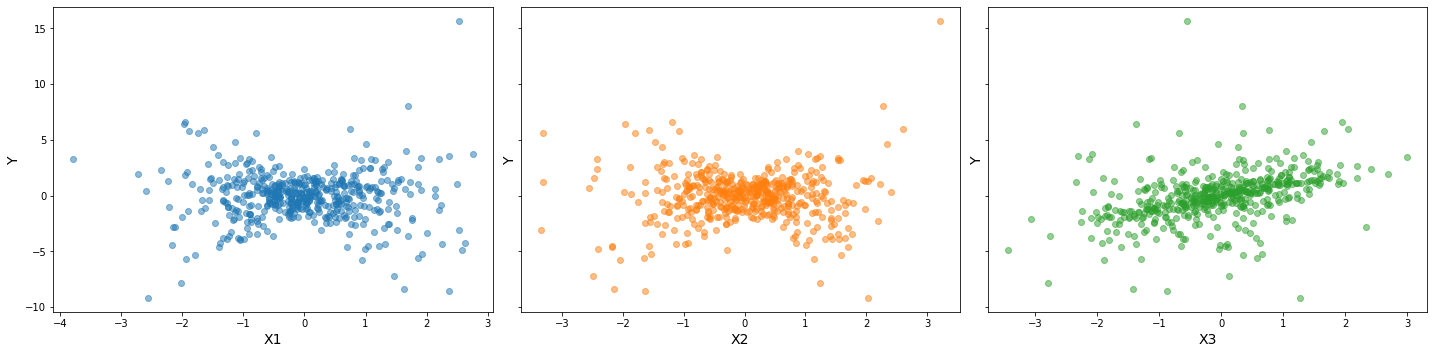

In [ ]:
fig, ax = plt.subplots( figsize=(20,5), ncols=3, nrows=1, sharey=True )

ax[0].plot( x[:,0], Y, 'C0o', alpha=.5 )
ax[0].set_xlabel('X1', fontsize=14)
ax[0].set_ylabel('Y', fontsize=14)
# ax[0].set_xlim([-3.1,3.1])
rs = np.arange( -2, 2, 0.5 )
# for r in rs:
#     ax[0].axvline( r, color='gray', linestyle='--', alpha=.6 )

ax[1].plot( x[:,1], Y, 'C1o', alpha=.5 )
ax[1].set_xlabel('X2', fontsize=14)
ax[1].set_ylabel('Y', fontsize=14)
# ax[1].set_xlim([-3.1,3.1])
rs = np.arange( -0.4, 0.4, 0.1 )
# for r in rs:
#     ax[1].axvline( r, color='gray', linestyle='--', alpha=.6 )

ax[2].plot( x[:,2], Y, 'C2o', alpha=.5 )
ax[2].set_xlabel('X3', fontsize=14)
ax[2].set_ylabel('Y', fontsize=14)
# ax[2].set_xlim([-3.1,3.1])
rs = np.arange( -0.5, 0.6, 0.15 )
# for r in rs:
#     ax[2].axvline( r, color='gray', linestyle='--', alpha=.6 )

fig.tight_layout(pad=1);

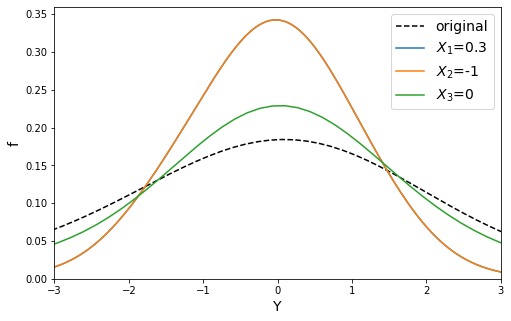

In [ ]:
Y1 = 2*(0)*x[:,1] + x[:,2]
Y2 = 2*x[:,0]*(0) + x[:,2]
Y3 = 2*x[:,0]*x[:,1] + 0

fig, ax = plt.subplots( figsize=(8,5) )

sns.kdeplot( Y, ax=ax, color='k', linestyle='--', label='original', bw_adjust=2 )
sns.kdeplot( Y1, ax=ax, label=r'$X_1$=0.3', bw_adjust=2 )
sns.kdeplot( Y2, ax=ax, label=r'$X_2$=-1', bw_adjust=2 )
sns.kdeplot( Y3, ax=ax, label=r'$X_3$=0', bw_adjust=2 )

ax.set_xlabel('Y',fontsize=14)
ax.set_ylabel('f', fontsize=14)
ax.set_xlim([-3,3])
ax.legend( fontsize=14 )

In [ ]:
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['X1','X2','X3'],
    'bounds': [[0,1],[0,1],[0,1]],
    'dists': ['norm', 'norm', 'norm']
}

# Simulaciones
X = saltelli.sample(problem, 2048, calc_second_order=False)

# Evaluaciones
Y = 2*X[:,0]* X[:,1] + X[:,2]

# Cómputo de índices
sobol_indices = sobol.analyze(problem, Y, calc_second_order=False)

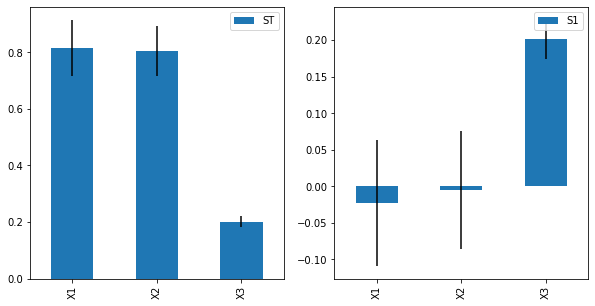

In [ ]:
# Cómputo de índices
sobol_indices = sobol.analyze(problem, Y, calc_second_order=False);

ax = sobol_indices.plot()
fig = ax[0].get_figure()
fig.set_size_inches(10,5);

## Ejemplo 4: SA del modelo de bielas

In [ ]:
# Función externa
def f_SA(beta):
    E, alpha, A, sY = beta # Parámetros a calibrar
    _, a = nonlinear_truss( A, E, alpha, sY, 300, 200, np.array([201]) )
    return a[0]

### Índices de Sobol

In [ ]:
# Define the model inputs
problem = {
    'num_vars': 4,
    'names': ['E', 'alpha', 'A', 'sy'],
    'bounds': [[15000,50000],[0.01,0.5],[1,10],[20,60]]
}

# Simulaciones
param_values = saltelli.sample(problem, 2048, calc_second_order=False)

# Evaluaciones
y = np.zeros( param_values.shape[0] )
for i in range( param_values.shape[0] ):
    y[i] = f_SA( param_values[i] )

# Cómputo de índices
sobol_indices = sobol.analyze(problem, y, calc_second_order=False)

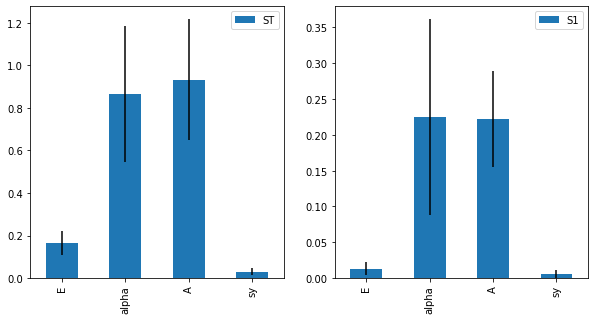

In [ ]:
# Ploteo
ax = sobol_indices.plot()
fig = ax[0].get_figure()
fig.set_size_inches(10,5);

### Efectos Elementales: Método de Morris

In [ ]:
import SALib.sample.morris as morris_sample
import SALib.analyze.morris as morris_analyze

In [ ]:
# Define the model inputs
problem = {
    'num_vars': 5,
    'names': ['Py', 'E', 'alpha', 'A', 'sy'],
    'bounds': [[0,1000],[15000,50000],[0.01,0.5],[1,10],[20,60]]
}

# Simulaciones
param_values = morris_sample.sample(problem, 1000, num_levels=4)

# Evaluaciones
y = np.zeros( param_values.shape[0] )
for i in range( param_values.shape[0] ):
    y[i] = f_SA( param_values[i] )

# Cómputo de índices
EE_indices = morris_analyze.analyze(problem, param_values, y, conf_level=0.95,
                                    print_to_console=True, num_levels=6)

              mu    mu_star       sigma  mu_star_conf
Py     19.082423  19.082423   52.351033      3.081392
E     -35.426285  35.426285  108.447889      5.746879
alpha -77.732198  77.732198  188.089227     11.112741
A     -83.396317  83.396317  197.576356     12.848611
sy     -9.151519   9.151519   20.411582      1.377685


## Ejemplo 5: Identificabilidad de parámetros

SA de la verosimilitud de un modelo

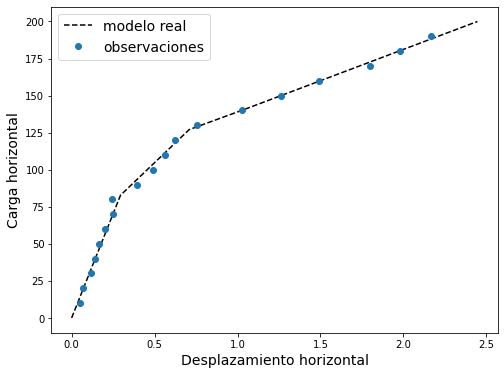

In [ ]:
np.random.seed(523)

# Creación de observaciones a partir de un modelo "real" más ruido
A = 4
E_true = 29000
Pmax = 200
Py = 300
sY = 36
alpha_true = 0.15
x = np.arange( 10, Pmax, 10 )
data, disp_out = nonlinear_truss( A, E_true, alpha_true, sY, Py, Pmax, x )
y = disp_out + st.norm.rvs( size=x.size, scale=0.02 )

# Ploteo de obsrevaciones sintéticas
fig, ax = plt.subplots( figsize=(8,6) )
ax.plot(data[:,0], data[:,1],'k--', label='modelo real')
ax.plot( y, x, 'C0o', label='observaciones' )
ax.set_xlabel('Desplazamiento horizontal', fontsize=14)
ax.set_ylabel('Carga horizontal', fontsize=14)
ax.legend( fontsize=14 );

In [ ]:
# Función de verosimilitud
def truss(beta):
    E, alpha, A, sY = beta # Parámetros a calibrar
    _, a = nonlinear_truss( A, E, alpha, sY, 300, 200, x )
    return a

# Función de Log-verosimilitud no-normalizada
def NormalLikelihood( beta ):
    # Desplazamientos del reticulado para cada x observado
    d = truss( beta )
    # Log verosimilitud
    logl = - np.sum( (y - d)**2 )
    return logl

In [ ]:
# Define the model inputs
problem = {
    'num_vars': 4,
    'names': ['E', 'alpha', 'A', 'sy'],
    'bounds': [[10,0.5],[0.01,0.6],[1,10],[20,60]],
    'dists': ['lognorm','unif','unif','unif']
}

# Simulaciones
param_values = saltelli.sample(problem, 2**14, calc_second_order=False)

# Evaluaciones
Y = np.zeros( param_values.shape[0] )
for i in range( param_values.shape[0] ):
    Y[i] = NormalLikelihood( param_values[i] )

# Cómputo de índices
sobol_indices = sobol.analyze(problem, Y, calc_second_order=False)

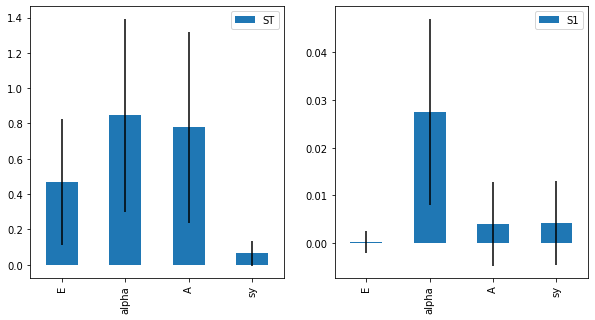

In [ ]:
ax = sobol_indices.plot()
fig = ax[0].get_figure()
fig.set_size_inches(10,5);